# Evaluating our model's predictions based on current home values (2019-10-01)

## Import necessary packages

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from python.predictor import melt_data, model_price, plot_models, plot_model_vs_real
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
all_df = pd.read_csv('raw_data/zillow_data.csv')
no_nan_df = pd.concat([all_df['RegionName'], all_df.loc[:, '2005-04': '2018-04']], axis=1).dropna()
stats_df = pd.read_csv('raw_data/stats.csv')
filtered_stats_df = stats_df.loc[stats_df['zipcode'].isin(no_nan_df['RegionName'])]
conservative5 = filtered_stats_df.nlargest(5, 'min_roi')
moderate5 = filtered_stats_df.nlargest(5, 'expected_roi')
potential5 = filtered_stats_df.nlargest(5, 'max_roi')

In [18]:
conservative_zip_forecasts = {}
for zipcode in conservative5['zipcode'].values:
    _, history_df, forecast_df, zipcode = model_price(all_df, zipcode, '2005-04-01', '2018-04-01')
    conservative_zip_forecasts[zipcode] = {'history': history_df, 'forecast': forecast_df}

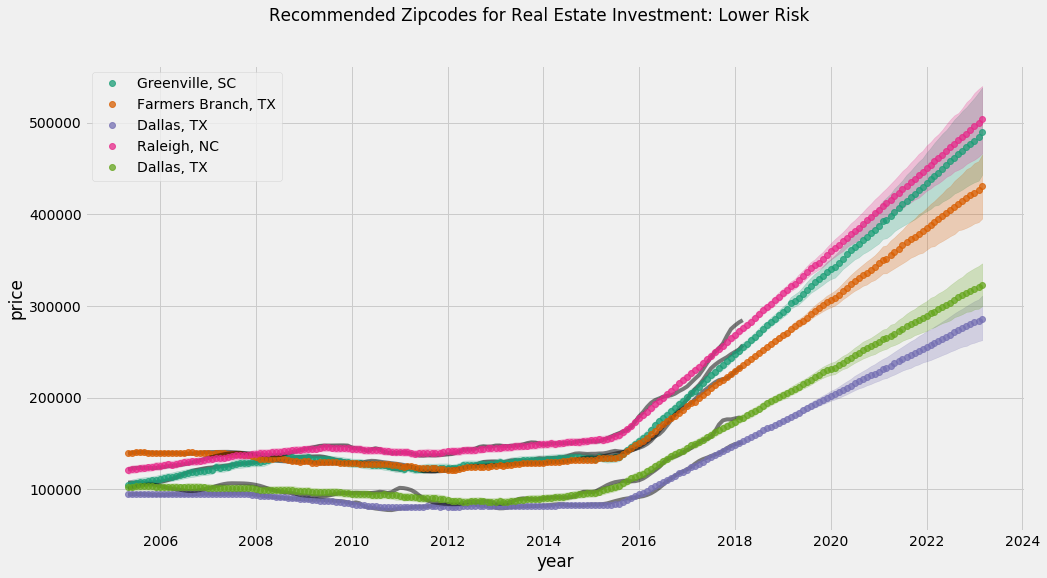

In [19]:
plot_models(all_df, stats_df, conservative_zip_forecasts, 'Lower Risk')

In [23]:
home_vals_2019 = pd.read_csv('raw_data/home_vals_2019.csv')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

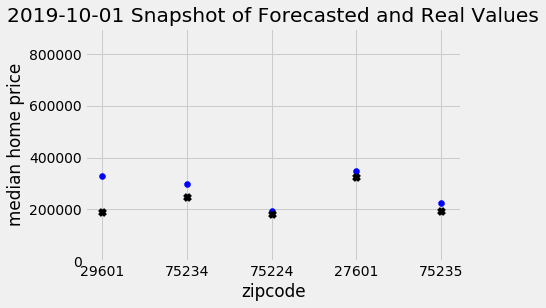

In [25]:
plot_model_vs_real(conservative_zip_forecasts, home_vals_2019, '2019-10-01')